# Import Packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

SEED = 1239

# Load Data


In [2]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [3]:
df_test = pd.read_csv('data/test.csv')
df_test.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [5]:
df_train.describe()

,id,num_sold
count,230130.000000,221259.000000
mean,115064.500000,752.527382
std,66432.953062,690.165445
min,0.000000,5.000000
25%,57532.250000,219.000000
50%,115064.500000,605.000000
75%,172596.750000,1114.000000
max,230129.000000,5939.000000


In [6]:
df_test.describe()

,id
count,98550.000000
mean,279404.500000
std,28449.078852
min,230130.000000
25%,254767.250000
50%,279404.500000
75%,304041.750000
max,328679.000000


In [7]:
df_train.nunique()

id          230130
date          2557
country          6
store            3
product          5
num_sold      4037
dtype: int64

In [8]:
df_test.nunique()

id         98550
date        1095
country        6
store          3
product        5
dtype: int64

In [9]:
print(df_train['country'].value_counts())
print()
print(df_train['store'].value_counts())
print()
print(df_train['product'].value_counts())

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64


## Convert dates to datetime

In [10]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

## Check for missing values

We see below that our target variable has 8871 missing values.

In [11]:
df_train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [12]:
df_test.isnull().sum()

id         0
date       0
country    0
store      0
product    0
dtype: int64

## Initial findings

We see above that the dataset has the features `id`, `date`, `country`, `store`, `product`, and target variable `num_sold`. The train set contains data from 2010 to 2016 and the test set is from 2017 to 2019. 

There are 6 different countries, 3 stores, and 5 products, all with equal proportions. These give us 90 (6 * 3 * 5) unique univariate time series. 

We also see that there are 8871 missing values for our target variable!

# EDA

## Distribution of Target Variable (num_sold)

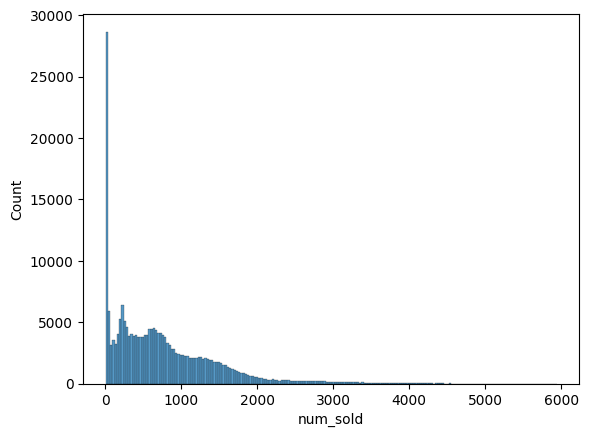

In [13]:
sns.histplot(df_train, x='num_sold');

## Monthly Sales Over Time

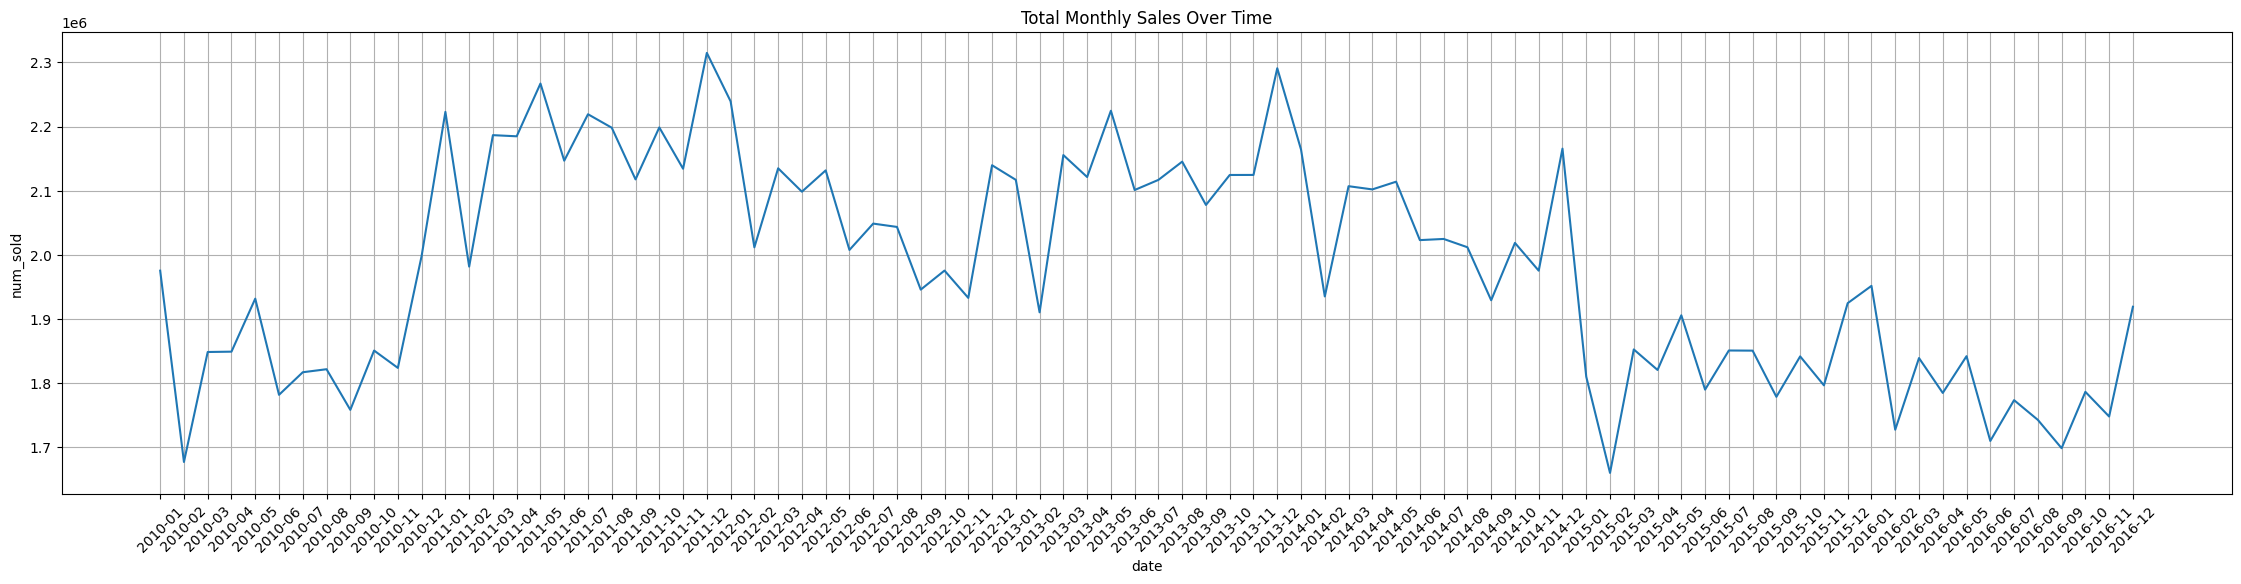

In [14]:
plt.figure(figsize=(28, 6))
ax = sns.lineplot(data=df_train.groupby([df_train.date.dt.strftime('%Y-%m')])['num_sold'].sum())
plt.grid()
ax.set_title('Total Monthly Sales Over Time')
plt.xticks(rotation = 45);
plt.show()

## Sales Over Time by Country

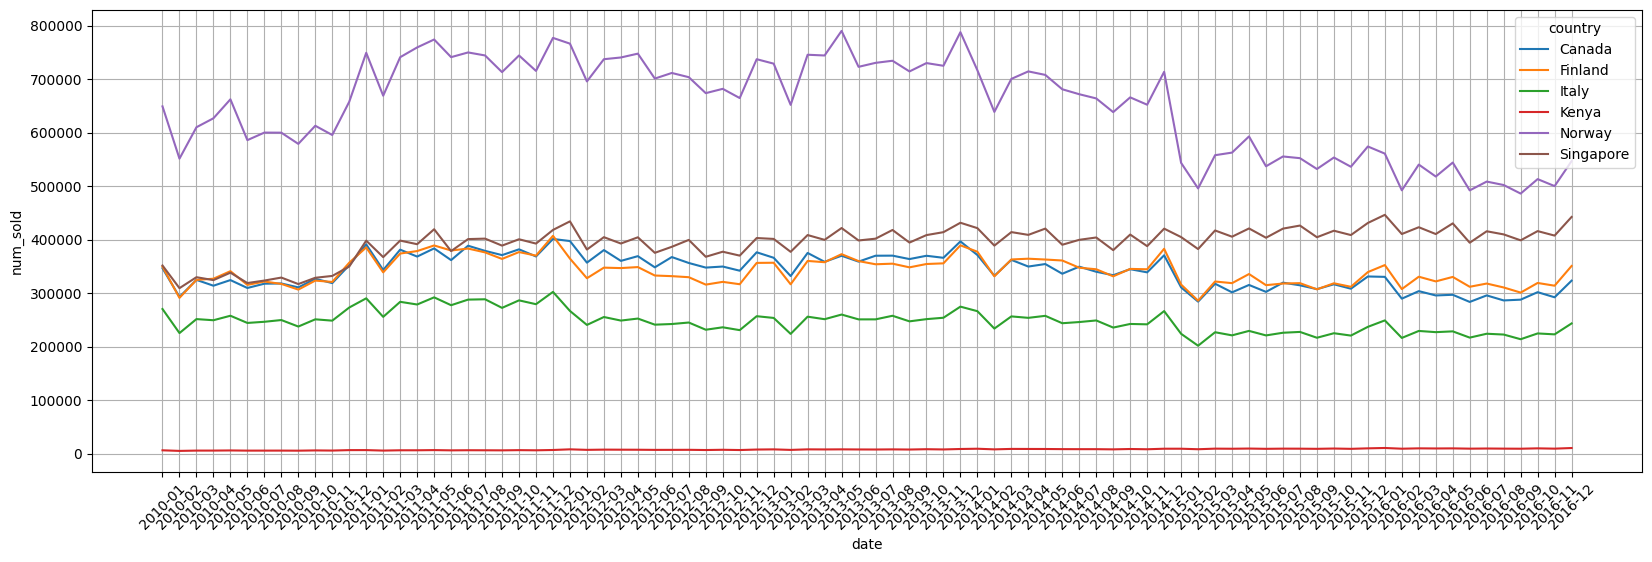

In [15]:
plt.figure(figsize = (20, 6))

sns.lineplot(data = df_train.groupby([df_train.date.dt.strftime('%Y-%m'), df_train.country])['num_sold'].sum().reset_index(),
                  x='date',
                  y='num_sold',
                  hue='country')
plt.grid()
plt.xticks(rotation = 45);

## Sales Over Time by Product

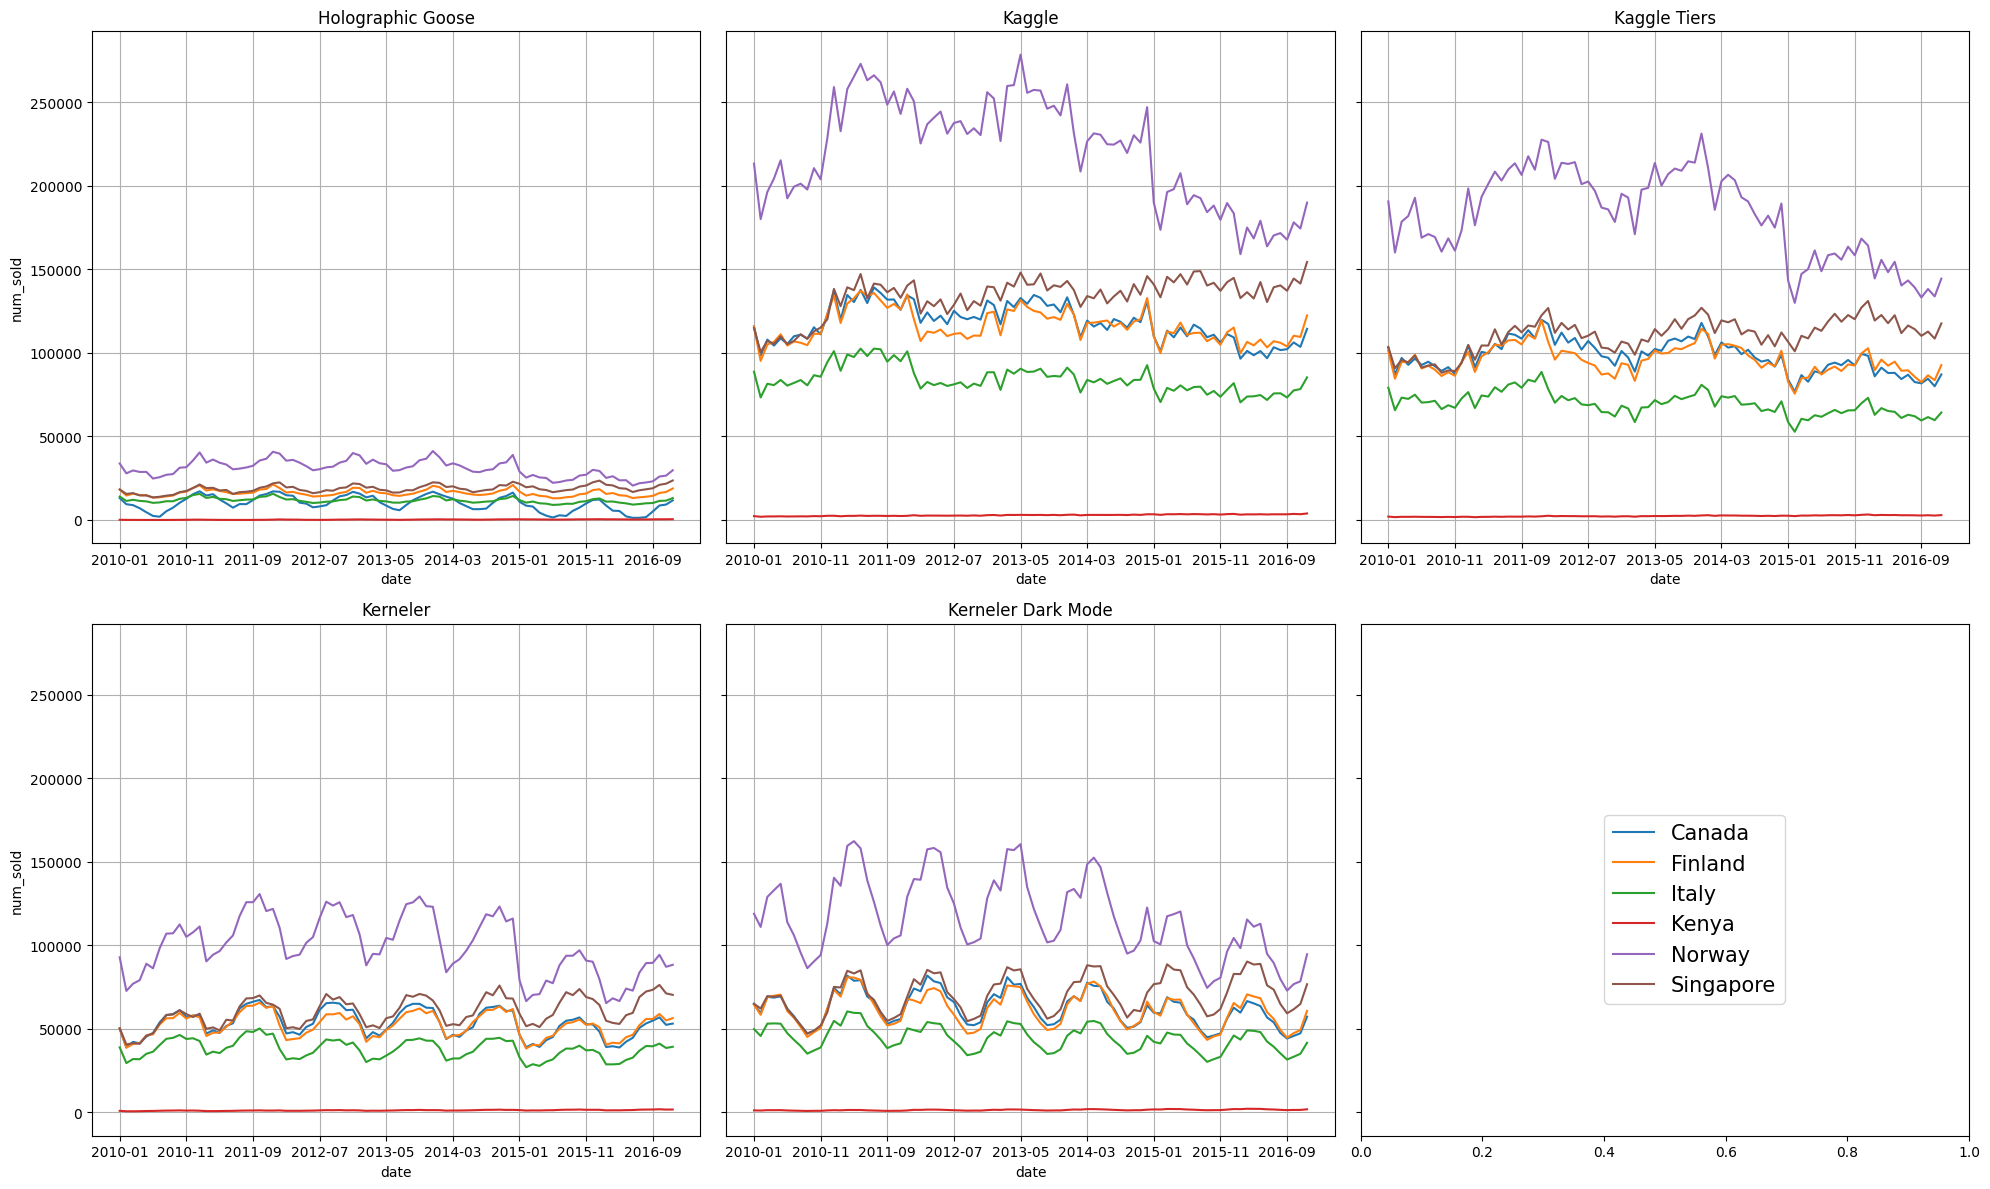

In [16]:
fig, ax = plt.subplots(2, 3, figsize = (20, 12), sharey = True)
ax = ax.flatten()
hue_order = df_train.country.unique()

for i, product in enumerate(df_train['product'].unique()):
    df = df_train[df_train['product'] == product]
    sns.lineplot(data = df.groupby([df.date.dt.strftime('%Y-%m'), df.country])['num_sold'].sum().reset_index(),
                 x = 'date',
                 y = 'num_sold',
                 hue = 'country',
                 ax = ax[i],
                 hue_order = hue_order
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    
    ax[i].legend().remove()
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].grid()
    
fig.legend(handles, labels, loc = 'lower right', bbox_to_anchor=(0.9, 0.15), fontsize = 15, ncol = 1)
plt.tight_layout()

We can see above that there is a seasonality to the sticker sales

## Missing Value Analysis

Let's dive deeper into the missing values of `num_sold`. 

We have 90 unique categories of country, store, and products and 230,130 total rows which means each category should have 230,130 / 90 = 2557 rows. Let's look at which categories contain missing values.

In [17]:
category_counts = df_train.groupby(["country","store","product"])["num_sold"].count().rename("count")
missing_category_counts = category_counts[category_counts < 2557]
missing_category_counts.reset_index()

,country,store,product,count
0,Canada,Discount Stickers,Holographic Goose,0
1,Canada,Discount Stickers,Kerneler,2556
2,Canada,Premium Sticker Mart,Holographic Goose,2177
3,Canada,Stickers for Less,Holographic Goose,1249
4,Kenya,Discount Stickers,Holographic Goose,0
5,Kenya,Discount Stickers,Kerneler,2494
6,Kenya,Discount Stickers,Kerneler Dark Mode,2556
7,Kenya,Premium Sticker Mart,Holographic Goose,1911
8,Kenya,Stickers for Less,Holographic Goose,1199


We see above that the Canada, Discount Stickers, Holographic Goose and Kenya, Discount Stickers, Holographic Goose categories have *all* their values missing.

### Visualize Missing Values in time series

Missing values are highlighted in red

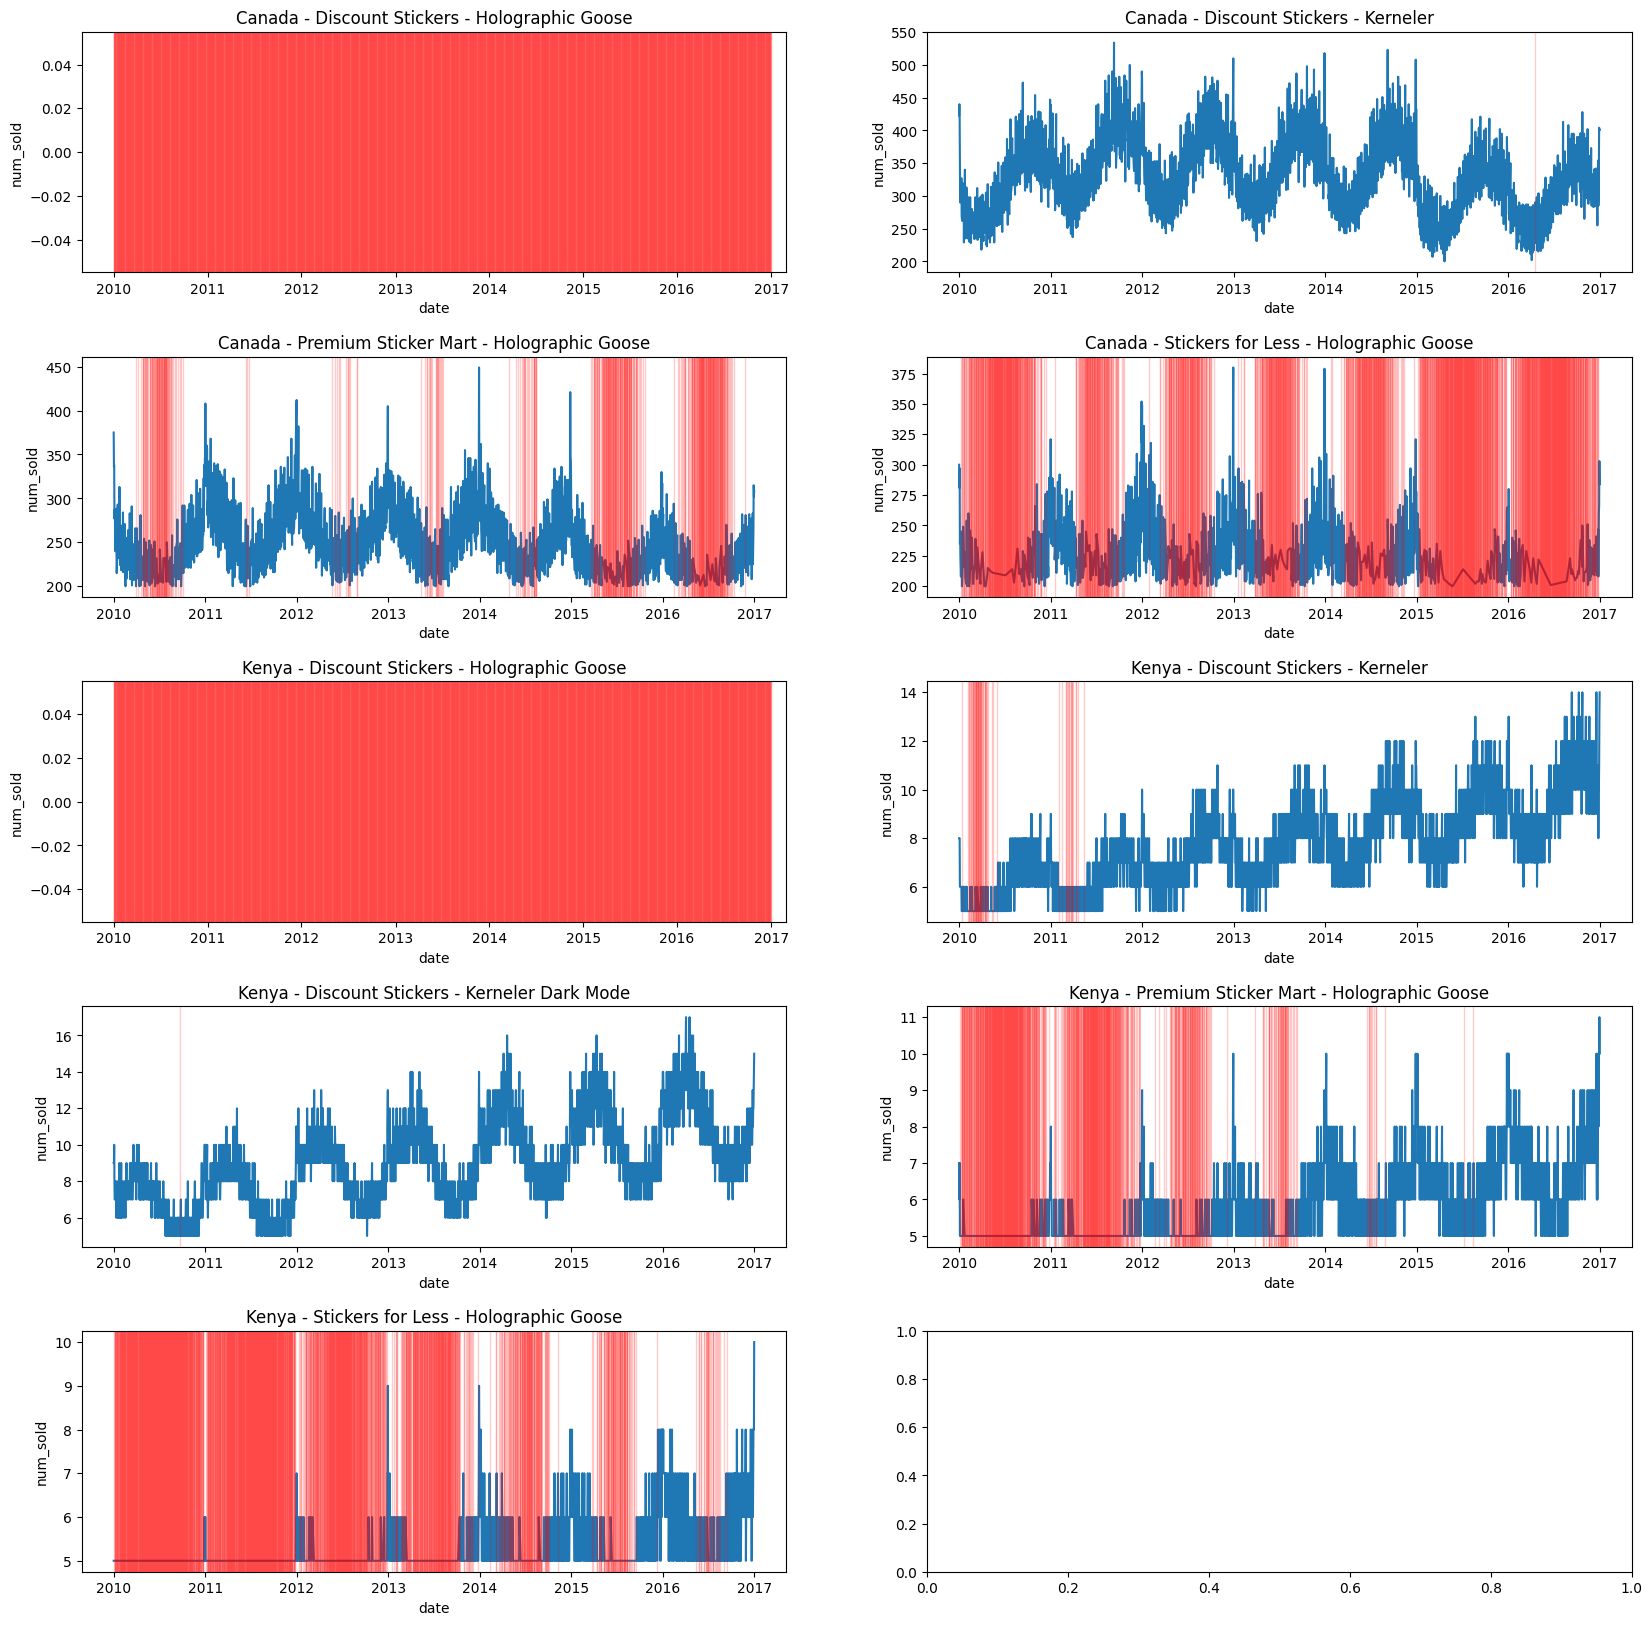

In [18]:
fig, ax = plt.subplots(5, 2, figsize=(20, 20))
ax = ax.flatten()

for i, (country, store, product) in enumerate(missing_category_counts.index):
    plot_df = df_train.loc[(df_train["country"] == country) & (df_train["store"] == store) & (df_train["product"] == product)]
    missing_vals = plot_df.loc[plot_df["num_sold"].isna()]
    sns.lineplot(plot_df, x="date", y="num_sold", ax=ax[i])
    for missing_date in missing_vals["date"]:
        ax[i].axvline(missing_date, color='red',  linestyle='-', linewidth=1, alpha=0.2)
    ax[i].set_title(f"{country} - {store} - {product}")

plt.subplots_adjust(hspace = 0.35)

We see above that there seems to be a pattern with the missing data. Days that have lower sales in Kenya and Canada appear to have their `num_sold` missing.

## Clean Data

In [19]:
def transform_date(df, col):
    df = df.copy()
    df[f'{col}_year'] = df[col].dt.year.astype('float32')
    df[f'{col}_month'] = df[col].dt.month.astype('float32')
    df[f'{col}_day'] = df[col].dt.day.astype('float32')
    df[f'{col}_day_of_week'] = df[col].dt.dayofweek.astype('float32')
    
    df[f'{col}_year_sin'] = np.sin(2 * np.pi * df[f'{col}_year'])
    df[f'{col}_year_cos'] = np.cos(2 * np.pi * df[f'{col}_year'])
    df[f'{col}_month_sin'] = np.sin(2 * np.pi * df[f'{col}_month'] / 12) 
    df[f'{col}_month_cos'] = np.cos(2 * np.pi * df[f'{col}_month'] / 12)
    return df

In [20]:
# remove null rows
df_train_clean = df_train.dropna()
# df_test_clean = df_test.dropna()

df_train_clean = transform_date(df_train_clean, 'date')
df_test_clean = transform_date(df_test, 'date')

# Label Encode
for col in ['country', 'store', 'product']:
    combined_data = pd.concat([df_train_clean[col], df_test_clean[col]])
    le = LabelEncoder()
    le.fit(combined_data)
    df_train_clean[col] = le.transform(df_train_clean[col])
    df_test_clean[col] = le.transform(df_test_clean[col])

y_train_full = df_train_clean['num_sold']

X_train_full = df_train_clean.drop(columns=['id', 'num_sold', 'date'])
X_test = df_test_clean.drop(columns=['id', 'date'])


## Time Series Cross Validation

We will use a time series based cross validation (`TimeSeriesSplit`) to account for the temporal ordering of the data

In [21]:
def fit_model_with_tss(X, y, model, n_splits=5):
    tss = TimeSeriesSplit(n_splits=n_splits)
    scores = []

    fold = 1

    for train_idx, val_idx in tss.split(X):
        print(f'    Training fold {fold}...', end='\r')
        fold += 1
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mape = mean_absolute_percentage_error(y_val, y_pred)
        scores.append(mape)
    print(' '*30, end='\r')
    
    return [np.mean(scores), np.std(scores)]


In [22]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=SEED, shuffle=False)

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177007 entries, 1 to 184278
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   country           177007 non-null  int64  
 1   store             177007 non-null  int64  
 2   product           177007 non-null  int64  
 3   date_year         177007 non-null  float32
 4   date_month        177007 non-null  float32
 5   date_day          177007 non-null  float32
 6   date_day_of_week  177007 non-null  float32
 7   date_year_sin     177007 non-null  float32
 8   date_year_cos     177007 non-null  float32
 9   date_month_sin    177007 non-null  float32
 10  date_month_cos    177007 non-null  float32
dtypes: float32(8), int64(3)
memory usage: 10.8 MB


# Model Training

- Linear Regression
- Random Forest
- XGBoost
- LightGBM

## Linear Regression

In [24]:
# Train a baseline model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_val)

# Evaluate
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred))

MAPE: 8.064218818800757


## Random Forest

In [ ]:
depths = [14, 15, 16, 17, 18, 19]

overall_scores = []
for d in depths:
    print(f'Trying d={d}')
    for n in range(10, 101, 10):
        print(f'    Training n = {n}...', end='\r')
        model = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=SEED,
                                        n_jobs=-1, min_samples_leaf=1)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mape = mean_absolute_percentage_error(y_val, y_pred)

        overall_scores.append((d, n, mape))
    print(' '*30, end='\r')


Trying d=13
Trying d=14                   
Trying d=15                   
Trying d=16                   
Trying d=17                   
Trying d=18                   
Trying d=19                   


In [26]:
columns = ['max_depth', 'n_estimators', 'mape']
df_scores = pd.DataFrame(overall_scores, columns=columns)

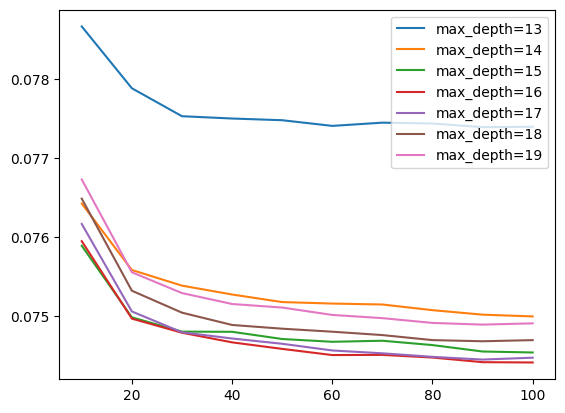

In [27]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.mape,
            label='max_depth=%d' % d)
    

plt.legend()

In [28]:
best_max_depth = 15

In [29]:
scores = []
min_samples = [1, 2, 3, 4, 5]

for s in min_samples:
    print(f'Trying min_samples={s}')
    for n in range(10, 101, 10):
        model = RandomForestRegressor(n_estimators=n,
                                    max_depth=best_max_depth,
                                    min_samples_leaf=s,
                                    random_state=SEED)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)

        scores.append((s, n, mape))

Trying min_samples=1
Trying min_samples=2
Trying min_samples=3
Trying min_samples=4
Trying min_samples=5


In [30]:
columns = ['min_samples_leaf', 'n_estimators', 'mape']
df_scores = pd.DataFrame(scores, columns=columns)

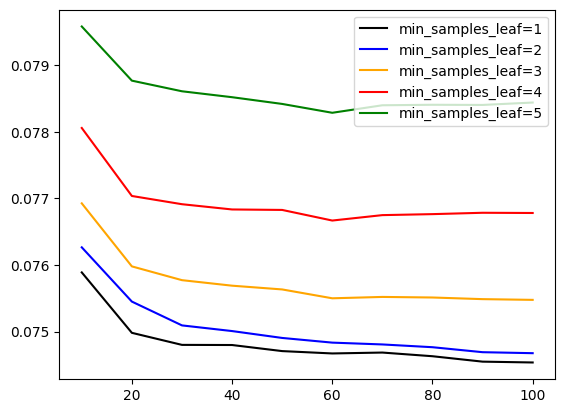

In [31]:
colors = ['black', 'blue', 'orange', 'red', 'green']

for s, col in zip(min_samples, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.mape,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [32]:
best_min_samples = 1

In [33]:
rf_final = RandomForestRegressor(n_estimators=100, max_depth=best_max_depth, random_state=SEED,
                                n_jobs=-1, min_samples_leaf=best_min_samples)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=1239)

### Feature Importance

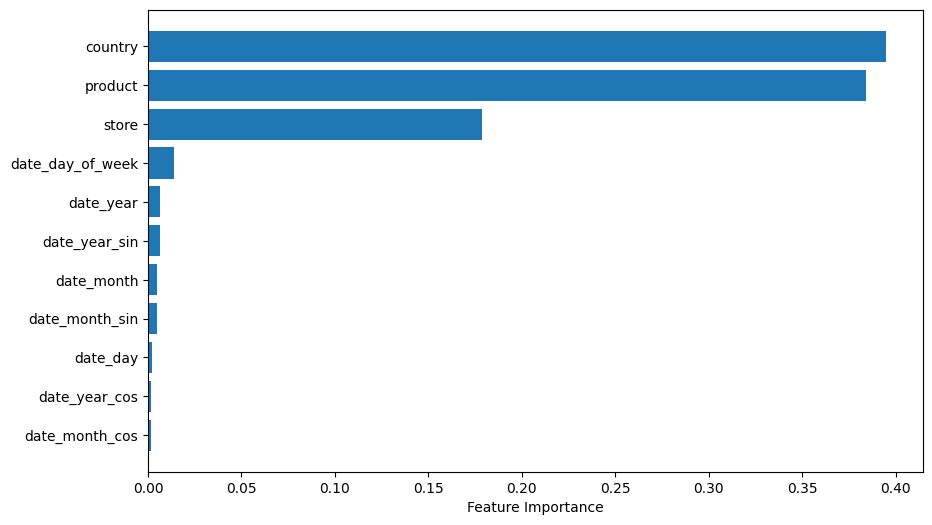

In [34]:
# Feature importance
importances = rf_final.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## XGBoost

In [35]:
params = {
    'learning_rate': 0.1, 
    'max_depth': 5,
    'min_child_weight': 1,
    'n_estimators': 100,
    
    'objective': 'reg:absoluteerror',
    'eval_metric': 'mape',

    'seed': SEED,
    'verbosity': 1,
    'n_jobs': -1
}

In [36]:
# params = xgb_default_params.copy()
depths = [5, 8, 10, 12]

overall_scores = []
for d in depths:
    print(f'Trying d={d}')
    params['max_depth'] = d
    for n in range(1, 101, 10):
        params['n_estimators'] = n
        model = XGBRegressor(**params)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        overall_scores.append((d, n, mape))



Trying d=5
Trying d=8
Trying d=10
Trying d=12


In [37]:
columns = ['max_depth', 'n_estimators', 'mape']
df_scores = pd.DataFrame(overall_scores, columns=columns)

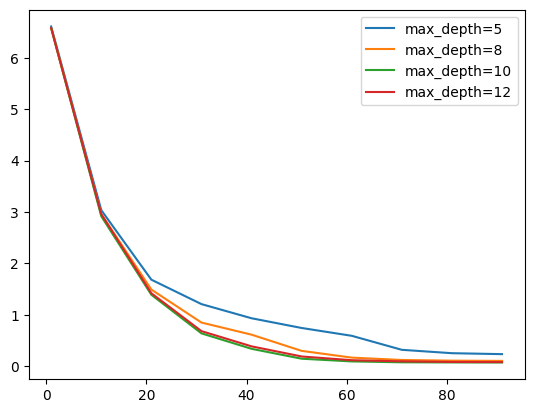

In [38]:
for d in depths:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.mape,
            label='max_depth=%d' % d)

plt.legend()

In [39]:
best_max_depth = 10
params['max_depth'] = best_max_depth

In [40]:
# params = xgb_default_params.copy()
learning_rates = [0.01, 0.05, 0.1]

overall_scores = []
for lr in learning_rates:
    print(f'Trying learning_rate={lr}')
    params['learning_rate'] = lr
    for n in range(1, 101, 10):
        params['n_estimators'] = n
        model = XGBRegressor(**params)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        overall_scores.append((lr, n, mape))

Trying learning_rate=0.01
Trying learning_rate=0.05
Trying learning_rate=0.1


In [41]:
columns = ['learning_rate', 'n_estimators', 'mape']
df_scores = pd.DataFrame(overall_scores, columns=columns)

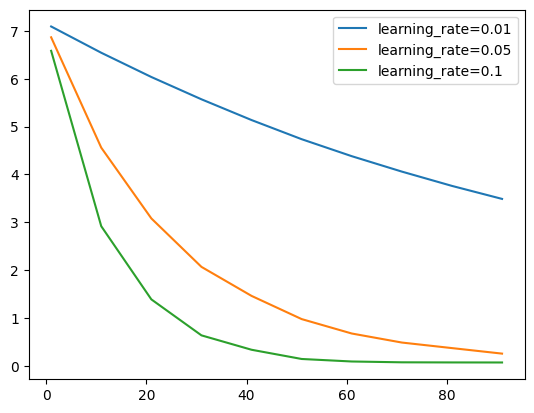

In [42]:
for r in learning_rates:
    df_subset = df_scores[df_scores.learning_rate == r]
    
    plt.plot(df_subset.n_estimators, df_subset.mape,
            label=f'learning_rate={r}')

plt.legend()

In [43]:
params['learning_rate'] = 0.1

In [44]:
min_child_weights = [5, 15, 30, 40]

overall_scores = []
for w in min_child_weights:
    print(f'Trying min_child_weight={w}')
    params['min_child_weight'] = w
    for n in range(1, 101, 10):
        params['n_estimators'] = n
        model = XGBRegressor(**params)
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_val)
        mape = mean_absolute_percentage_error(y_val, y_pred)
        overall_scores.append((w, n, mape))

Trying min_child_weight=5
Trying min_child_weight=15
Trying min_child_weight=30
Trying min_child_weight=40


In [45]:
columns = ['min_child_weights', 'n_estimators', 'mape']
df_scores = pd.DataFrame(overall_scores, columns=columns)

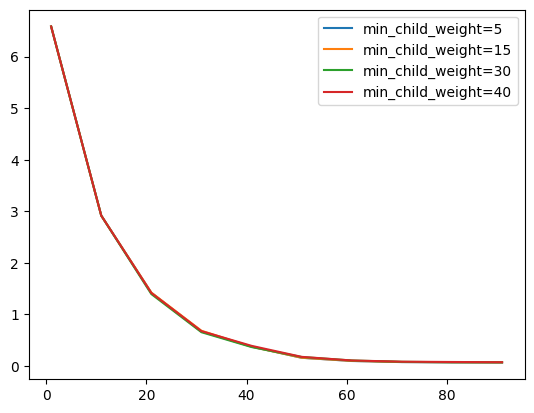

In [46]:
for w in min_child_weights:
    df_subset = df_scores[df_scores.min_child_weights == w]
    
    plt.plot(df_subset.n_estimators, df_subset.mape,
            label=f'min_child_weight={w}')


plt.legend()

In [47]:
params['min_child_weight'] = 5

In [48]:
xgb_final = XGBRegressor(**params)

## Selecting Final Model

We evaluate our models using time series split

In [49]:
classifiers = [lr_model, rf_final, xgb_final]

model_scores = []
for model in classifiers:
    model_name = model.__class__.__name__
    print(f'Fitting {model_name}')
    score = fit_model_with_tss(X_train_full, y_train_full, model)
    model_scores.append((model_name, *score))

Fitting LinearRegression
Fitting RandomForestRegressor 
Fitting XGBRegressor          


In [50]:
for name, mean, std in model_scores:
    print(f'{name: <22} mean: {mean:.4f}, std: +- {std:.4f}')

LinearRegression       mean: 9.6345, std: +- 0.8332
RandomForestRegressor  mean: 0.0871, std: +- 0.0168
XGBRegressor           mean: 0.1132, std: +- 0.0301


Our Random Forest is the best performing model

In [52]:
rf_final.fit(X_train, y_train)
final_pred = rf_final.predict(X_test)